In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors
from matplotlib.ticker import MaxNLocator
from matplotlib import rcParams

import sys
import os
import glob2
from tqdm import tqdm

import ast
import pandas as pd

from chatty_boi import *
import re
import seaborn as sns
import matplotlib.colors as mcolors


In [2]:
with open("./prompt_lib/base_prompt.txt", "r") as f:
    prompt = f.read()

with open("./prompt_lib/constraint_prompt.txt", "r") as f:
    constraints_prompt = f.read()

with open("./prompt_lib/optimize_prompt.txt", "r") as f:
    optimize_prompt = f.read()

input_data = {}
with open("./prompt_lib/base_inputs.txt", "r") as f:
    exec(f.read(),{}, input_data)


base_prompt = prompt
constraints_prompt = constraints_prompt
optimize_prompt = optimize_prompt

node_dict_input = input_data["node_dict_input"]
example_members_input = input_data["example_members_input"]
area_id = input_data["area_id"]
load = input_data["load"]
supports = input_data["supports"]


In [3]:
base_dir = './results_final_runs/responses_q1/'
pattern = os.path.join(base_dir, '*', 'run_*', '_step_*_*')
all_files = glob2.glob(pattern)

In [4]:
len(all_files)


1001

In [5]:

def parse_info(s):
    match = re.search(
        r'q(\d+)p(\d+)_s(\d+)W(\d+)_([\w\d]+)_t(\d+)(?:/run_(\d+)/_step_(\d+)_(\d+))?', s
    )
    if match:
        groups = match.groups()
        task = int(groups[0])
        variation = int(groups[1])
        max_stress = int(groups[2])
        max_weight = int(groups[3])
        model = groups[4]

        temp_raw = int(groups[5])
        temp = 1 if temp_raw == 1 else temp_raw / 10.0
        
        run_id = int(groups[6]) if groups[6] else None
        step = int(groups[7]) if groups[7] else None
        attempt = int(groups[8]) if groups[8] else None
        
        return {
            'task': task,
            'variation': variation,
            'max_stress': max_stress,
            'max_weight': max_weight,
            'model': model,
            'temp': temp,
            'run_id': run_id,
            'step': step,
            'attempt': attempt
        }
    else:
        return None

# Your all_files list
parsed_list = [parse_info(f) for f in all_files]
df = pd.DataFrame(parsed_list)
df = df.dropna()

# Correct total steps and attempts calculation
def compute_totals(subdf):
    total_steps = subdf['step'].nunique()  # number of unique steps
    total_attempts = (subdf['attempt'] + 1).sum()  # (attempt + 1) summed
    return pd.Series({
        'total_steps': total_steps,
        'total_attempts': total_attempts
    })

final_df = df.groupby(
    ['task', 'variation', 'max_stress', 'max_weight', 'model', 'temp', 'run_id']
).apply(compute_totals).reset_index()


/tmp/ipykernel_394316/3856556204.py:50: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  ).apply(compute_totals).reset_index()


In [6]:
final_df[final_df["run_id"] == 6]

,task,variation,max_stress,max_weight,model,temp,run_id,total_steps,total_attempts
6,1,1,15,30,gpt,0.5,6,9,10
16,1,1,15,30,gpt,1.0,6,5,9
26,1,1,15,30,gpt,1.2,6,5,8
36,1,1,15,30,mini,0.5,6,9,10
46,1,1,15,30,mini,1.0,6,2,3
56,1,1,15,30,mini,1.2,6,5,5
66,1,2,20,30,gpt,0.5,6,7,9
76,1,2,20,30,gpt,1.0,6,4,5
86,1,2,20,30,gpt,1.2,6,2,2
96,1,2,20,30,mini,0.5,6,7,7


In [7]:
f1 = all_files[3]

with open(f1, "r") as f:
    content = ast.literal_eval(f.read())
    parsed = TrussOutput.model_validate(content)

t = make_truss(parsed.node_dict,parsed.member_dict, load, supports)

_, res = make_result_dict(t.member_stress(), t.structure_mass(), print_=True)

Max stress to weight ratio:  0.3484
Max stress:  7.1087
Total mass:  20.4015
Member mass:  {'member_1': 3.518, 'member_2': 3.128, 'member_3': 4.0058, 'member_4': 2.9509, 'member_5': 5.6288, 'member_6': 1.17}
Member stress:  {'member_1': -5.2886, 'member_2': -2.8536, 'member_3': 4.8249, 'member_4': 7.1087, 'member_5': -4.0199, 'member_6': -3.6653}


In [8]:
file_info_list = []

for file in all_files:
    parsed = parse_info(file)
    if parsed:
        parsed['filepath'] = file
        file_info_list.append(parsed)

df_files = pd.DataFrame(file_info_list)

# Prepare columns
final_df['best_structure'] = None
final_df['best_result'] = None
final_df['best_max_stress'] = None
final_df['best_total_mass'] = None
final_df['best_max_stress_to_weight_ratio'] = None
final_df['success'] = None  
final_df['best_node'] = None
final_df['best_member'] = None

for idx, row in final_df.iterrows():
    mask = (
        (df_files['task'] == row['task']) &
        (df_files['variation'] == row['variation']) &
        (df_files['max_stress'] == row['max_stress']) &
        (df_files['max_weight'] == row['max_weight']) &
        (df_files['model'] == row['model']) &
        (df_files['temp'] == row['temp']) &
        (df_files['run_id'] == row['run_id'])
    )
    
    matching_files = df_files[mask]
    
    best_structure = None
    best_result = None
    best_score = np.inf
    best_max_stress = None
    best_total_mass = None
    best_max_stress_to_weight_ratio = None

    
    
    for fpath in matching_files['filepath']:
        with open(fpath, "r") as f:
            content = ast.literal_eval(f.read())
        
        parsed = TrussOutput.model_validate(content)
        t = make_truss(parsed.node_dict, parsed.member_dict, load, supports)
        _, res = make_result_dict(t.member_stress(), t.structure_mass(), print_=False)
        
        # Check if structure satisfies the constraints
        if abs(res['max_stress']) <= row['max_stress'] and res['total_mass'] <= row['max_weight']:
            score = res['max_stress']  # or res['max_stress_to_weight_ratio'], etc.
            
            if score < best_score:
                best_score = score
                best_structure = t
                best_result = res
                best_node = parsed.node_dict
                best_member = parsed.member_dict
                best_max_stress = res["max_stress"]
                best_total_mass = res["total_mass"]
                best_max_stress_to_weight_ratio = res["max_stress_to_weight_ratio"]

    # After looping through all files for this run
    final_df.at[idx, 'best_structure'] = best_structure
    final_df.at[idx, 'best_result'] = best_result
    final_df.at[idx, 'best_max_stress'] = best_max_stress
    final_df.at[idx, 'best_total_mass'] = best_total_mass
    final_df.at[idx, 'best_max_stress_to_weight_ratio'] = best_max_stress_to_weight_ratio
    final_df.at[idx, 'best_node'] = best_node
    final_df.at[idx, 'best_member'] = best_member

    if best_max_stress is not None and best_total_mass is not None:
        final_df.at[idx, 'success'] = ((best_max_stress) <= row['max_stress']) and (best_total_mass <= row['max_weight'])
    else:
        final_df.at[idx, 'success'] = False  # No feasible structure found



In [9]:
final_df

#save padnas dataframe as pd
final_df.to_pickle("./results_final_runs/final_df_q1.pkl")

In [10]:
# Assume final_df is ready

# Group by the main parameters you asked
agg_df = final_df.groupby(
    ['task', 'variation', 'model', 'temp', 'max_stress', 'max_weight']
).agg(

    best_stress=('best_max_stress', 'min'),
    mean_best_stress=('best_max_stress', 'mean'),
    std_best_stress=('best_max_stress', 'std'),

    best_mass=('best_total_mass', 'min'),
    mean_best_mass=('best_total_mass', 'mean'),
    std_best_mass=('best_total_mass', 'std'),

    mean_steps=('total_steps', 'mean'),
    std_steps=('total_steps', 'std'),
    mean_attempts=('total_attempts', 'mean'),
    std_attempts=('total_attempts', 'std'),
   
    
).reset_index()

# Done
(agg_df)


,task,variation,model,temp,max_stress,max_weight,best_stress,mean_best_stress,std_best_stress,best_mass,mean_best_mass,std_best_mass,mean_steps,std_steps,mean_attempts,std_attempts
0,1,1,gpt,0.5,15,30,5.5513,8.9123,2.041193,18.326,24.38066,4.472038,5.3,3.267687,6.0,3.231787
1,1,1,gpt,1.0,15,30,5.4982,8.68353,2.563381,11.7272,21.81442,5.247932,4.9,2.998148,5.9,3.604010
2,1,1,gpt,1.2,15,30,5.4821,8.92129,1.744519,15.4587,23.37661,4.869415,5.0,3.197221,7.4,4.623611
3,1,1,mini,0.5,15,30,4.3139,8.95233,2.580900,16.3865,24.96939,4.504865,6.9,6.674162,8.4,7.961016
4,1,1,mini,1.0,15,30,4.0199,7.36228,1.681683,22.2916,26.54536,2.317583,7.8,6.460134,9.3,7.818070
5,1,1,mini,1.2,15,30,5.3017,8.16521,3.563657,20.4242,26.72982,2.681447,9.9,6.208417,12.8,7.969386
6,1,2,gpt,0.5,20,30,4.7836,9.37634,2.692439,12.3179,19.07545,5.345236,4.0,1.825742,4.3,2.311805
7,1,2,gpt,1.0,20,30,6.7397,11.72668,2.544129,14.5289,23.62796,5.215498,4.9,2.685351,6.2,3.583915
8,1,2,gpt,1.2,20,30,8.1389,11.89272,3.515497,11.3567,20.68966,6.456413,4.3,2.110819,5.4,2.756810
9,1,2,mini,0.5,20,30,5.6442,10.30772,2.836813,12.7912,22.04454,4.941913,5.2,3.852849,6.1,4.748099


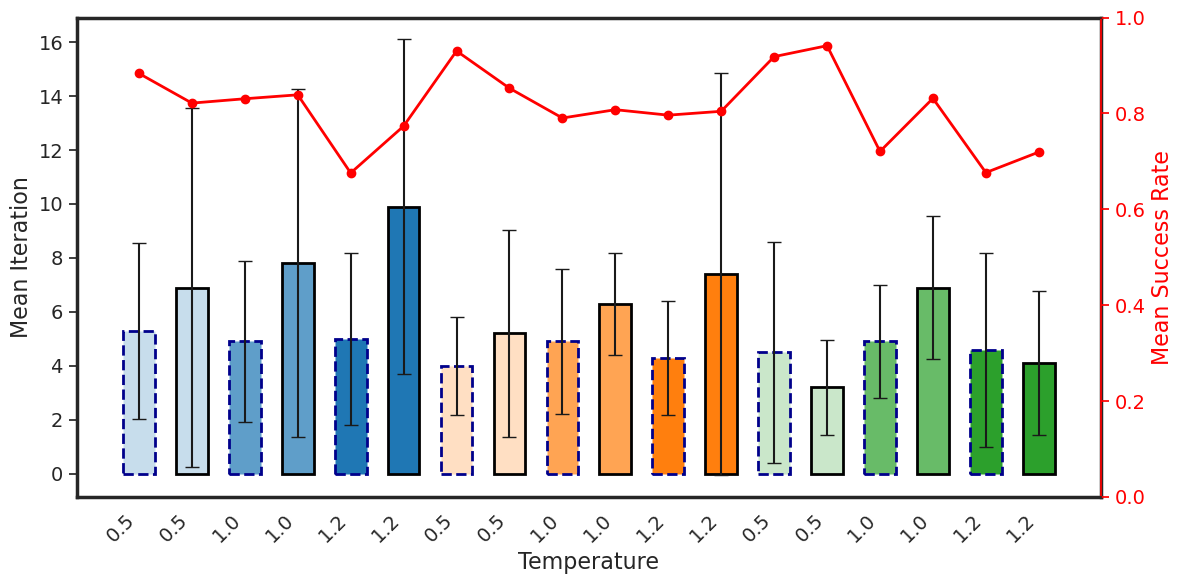

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.colors as mcolors

# Assume agg_df is already defined with columns:
# ['model','variation','temp',
#  'mean_steps','std_steps','mean_attempts','std_attempts']

# 1) Compute success rate
agg_df['success_rate'] = agg_df['mean_steps'] / agg_df['mean_attempts']

# 2) Filter & sort
plot_df = agg_df[agg_df['variation'].isin([1, 2, 3])].copy()
plot_df.sort_values(['variation', 'temp'], inplace=True)
plot_df.reset_index(drop=True, inplace=True)

# 3) Color setup
base_variation_colors = {1: 'tab:blue', 2: 'tab:orange', 3: 'tab:green'}
def adjust_color_brightness(color, temp):
    base = np.array(mcolors.to_rgb(color))
    white = np.array([1, 1, 1])
    tn = (temp - 0.5) / (1.2 - 0.5)
    tn = np.clip(tn, 0.25, 1)
    return tuple(white * (1 - tn) + base * tn)

# 4) Plot setup
sns.set_theme(style="white")
x = np.arange(len(plot_df))
width = 0.6

fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot only mean_steps bars
for i, row in plot_df.iterrows():
    color = adjust_color_brightness(base_variation_colors[row['variation']], row['temp'])
    edgecol = '#00008B' if row['model']=='gpt' else 'black'
    ls = 'dashed' if row['model']=='gpt' else 'solid'
    ax1.bar(
        x[i], row['mean_steps'], width,
        yerr=row['std_steps'], capsize=5,
        color=color, edgecolor=edgecol,
        linewidth=2, linestyle=ls,
        label=f"Var {row['variation']}" if row['variation'] not in plot_df['variation'][:i].values else ""
    )

# 5) Success rate line on secondary axis
ax2 = ax1.twinx()
ax2.plot(
    x, plot_df['success_rate'], 
    color='red', marker='o', linestyle='-', linewidth=2,
    label='Success Rate'
)

# Color the success-rate axis red
ax2.tick_params(axis='y', colors='red', labelsize=14)
ax2.spines['right'].set_color('red')
ax2.set_ylabel('Mean Success Rate', fontsize=16, color='red')
ax2.set_ylim(0, 1)

# 6) Formatting primary axis
ax1.set_xticks(x)
ax1.set_xticklabels(plot_df['temp'].astype(str), rotation=45, ha='right', fontsize=14)
ax1.set_ylabel('Mean Iteration', fontsize=16)
ax1.set_xlabel('Temperature', fontsize=16)
ax1.tick_params(axis='y', labelsize=14)
ax1.grid(False)
for spine in ax1.spines.values():
    spine.set_linewidth(2.5)

# 7) Legend
h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
# ax1.legend(h1+h2, l1+l2, loc='upper left', fontsize=12)
plt.savefig('./figures/box_iteration_task1.png', dpi=600, bbox_inches='tight')
plt.tight_layout()
plt.show()


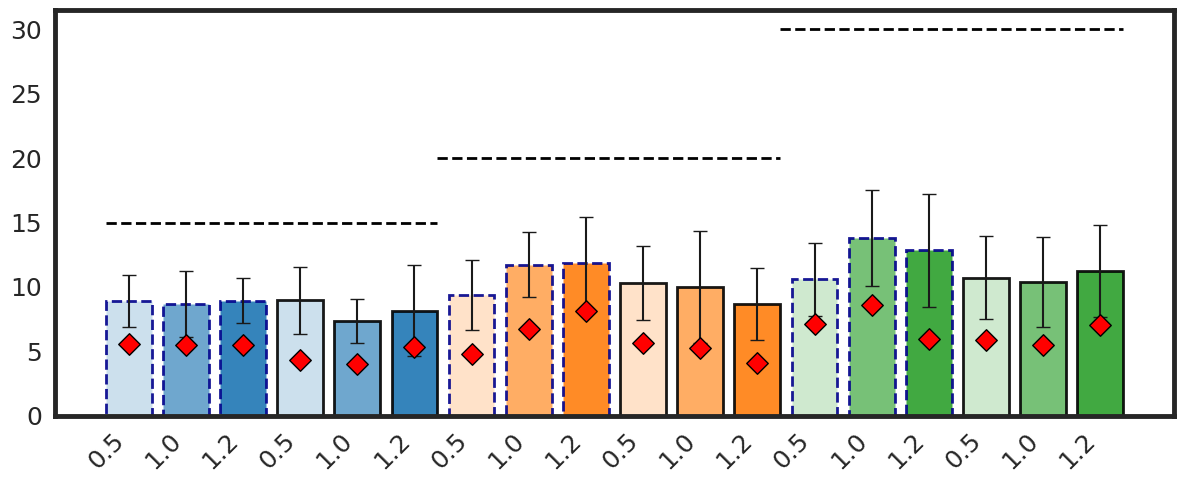

In [12]:


# Set seaborn style WITHOUT grid
sns.set_theme(style="white")

# Filter just variations 1, 2, 3
plot_df = agg_df[agg_df['variation'].isin([1, 2, 3])].copy()

# Create x-axis labels (Model-Temp)
plot_df['label'] = plot_df.apply(lambda row: f"{row['temp']}", axis=1)

# Base colors for variations
base_variation_colors = {
    1: 'tab:blue',
    2: 'tab:orange',
    3: 'tab:green'
}

# Correct shading function: interpolate between white and base color
def adjust_color_brightness(color, temp):
    base_color = np.array(mcolors.to_rgb(color))
    white = np.array([1, 1, 1])
    
    temp_norm = (temp - 0.5) / (1.2 - 0.5)  # normalize temp between 0 and 1
    temp_norm = np.clip(temp_norm, 0.25, 1)
    
    adjusted_color = white * (1 - temp_norm) + base_color * temp_norm
    return tuple(adjusted_color)

# Prepare bar positions
x = np.arange(len(plot_df))

# Create figure
fig, ax = plt.subplots(figsize=(12,5))

#
# Track plotted variations to avoid duplicate legends
plotted_variations = set()

# Plot bars manually
for i, (idx, row) in enumerate(plot_df.iterrows()):
    # Always pick base color by variation
    base_color = base_variation_colors[row['variation']]
    color = adjust_color_brightness(base_color, row['temp'])
    
    edgecolor = 'black'
    linestyle = 'solid'
    
    # Special dashed edge for GPT models
    if row['model'] == 'gpt':
        edgecolor = '#00008B'  # dark blue edge
        linestyle = 'dashed'
    
    label = f'Variation {row["variation"]}' if row['variation'] not in plotted_variations else ""
    
    bar = ax.bar(
        x[i],
        row['mean_best_stress'],
        yerr=row['std_best_stress'],
        capsize=5,
        color=color,
        edgecolor=edgecolor,
        linewidth=2,
        alpha=0.9,
        label=label
    )
    
    # If GPT, set dashed edge
    if row['model'] == 'gpt':
        bar[0].set_linestyle(linestyle)
    
    # Mark best_stress with a red diamond
    ax.scatter(
        x[i],
        row['best_stress'],
        color='red',
        marker='D',
        s=120,
        edgecolors='black',
        zorder=5
    )
    
    plotted_variations.add(row['variation'])

first_bar = x[0] - 0.4  # left edge
sixth_bar = x[5] + 0.4  # right edge

ax.hlines(
    y=15, xmin=first_bar, xmax=sixth_bar,
    colors='black', linestyles='dashed', linewidth=2
)

eleven_bar = x[11] + 0.4  # right edge
ax.hlines(
    y=20, xmin=sixth_bar, xmax=eleven_bar,
    colors='black', linestyles='dashed', linewidth=2
)

last_bar = x[-1] + 0.4  # right edge
ax.hlines(
    y=30, xmin=eleven_bar, xmax=last_bar,
    colors='black', linestyles='dashed', linewidth=2
)


# Set labels
ax.set_xticks(x)
ax.set_xticklabels(plot_df['label'], rotation=45, ha='right', fontsize=18)

# make y tick bigger
ax.tick_params(axis='y', labelsize=18)

# Remove grid
ax.grid(False)

#make thick borders
for spine in ax.spines.values():
    spine.set_visible(True)
    spine.set_linewidth(3.5)

# Add Legend
handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))

plt.tight_layout()
# plt.savefig("./figures/stress_plot_q1.png", dpi=600)
plt.show()


# FOR TASK 2

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors
from matplotlib.ticker import MaxNLocator
from matplotlib import rcParams

import sys
import os
import glob2
from tqdm import tqdm

import ast
import pandas as pd

from chatty_boi import *
import re
import seaborn as sns
import matplotlib.colors as mcolors


In [14]:
with open("./prompt_lib_swr/base_prompt_swr.txt", "r") as f:
    prompt = f.read()

with open("./prompt_lib_swr/constraint_prompt_swr.txt", "r") as f:
    constraints_prompt = f.read()

with open("./prompt_lib_swr/optimize_prompt_swr.txt", "r") as f:
    optimize_prompt = f.read()

input_data = {}
with open("./prompt_lib_swr/base_inputs_swr.txt", "r") as f:
    exec(f.read(),{}, input_data)


base_prompt = prompt
constraints_prompt = constraints_prompt
optimize_prompt = optimize_prompt

node_dict_input = input_data["node_dict_input"]
example_members_input = input_data["example_members_input"]
area_id = input_data["area_id"]
load = input_data["load"]
supports = input_data["supports"]


In [15]:
base_dir = './results_final_runs/responses_q2/'
pattern = os.path.join(base_dir, '*', 'run_*', '_step_*_*')
all_files = glob2.glob(pattern)

len(all_files)


981

In [16]:
def parse_info(s):
    match = re.search(
        r'q(\d+)p(\d+)_s(\d+)W(\d+)_([\w\d]+)_t(\d+)(?:/run_(\d+)/_step_(\d+)_(\d+))?', s
    )
    if match:
        groups = match.groups()
        task = int(groups[0])
        variation = int(groups[1])
        max_swr_raw = int(groups[2])  # Raw SWR
        max_weight = int(groups[3])
        model = groups[4]

        temp_raw = int(groups[5])

        # ✅ Correct SWR parsing
        if max_swr_raw == 1:
            max_swr = 1.0
        elif max_swr_raw < 10:
            max_swr = max_swr_raw / 10.0
        else:
            max_swr = max_swr_raw / 100.0
        
        # ✅ Temperature parsing
        temp = 1 if temp_raw == 1 else temp_raw / 10.0

        run_id = int(groups[6]) if groups[6] else None
        step = int(groups[7]) if groups[7] else None
        attempt = int(groups[8]) if groups[8] else None

        return {
            'task': task,
            'variation': variation,
            'max_swr': max_swr,
            'max_weight': max_weight,
            'model': model,
            'temp': temp,
            'run_id': run_id,
            'step': step,
            'attempt': attempt
        }


# Your all_files list
parsed_list = [parse_info(f) for f in all_files]
df = pd.DataFrame(parsed_list)
df = df.dropna()

# Correct total steps and attempts calculation
def compute_totals(subdf):
    total_steps = subdf['step'].nunique()  # number of unique steps
    total_attempts = (subdf['attempt'] + 1).sum()  # (attempt + 1) summed
    return pd.Series({
        'total_steps': total_steps,
        'total_attempts': total_attempts
    })

final_df = df.groupby(
    ['task', 'variation', 'max_swr', 'max_weight', 'model', 'temp', 'run_id']
).apply(compute_totals).reset_index()


/tmp/ipykernel_394316/3313223538.py:59: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  ).apply(compute_totals).reset_index()


In [17]:
final_df[final_df["run_id"] == 6]

,task,variation,max_swr,max_weight,model,temp,run_id,total_steps,total_attempts
6,2,1,0.50,30,gpt,0.5,6,13,14
16,2,1,0.50,30,gpt,1.0,6,4,5
26,2,1,0.50,30,gpt,1.2,6,3,3
36,2,1,0.50,30,mini,0.5,6,5,5
46,2,1,0.50,30,mini,1.0,6,3,4
56,2,1,0.50,30,mini,1.2,6,9,11
66,2,2,0.75,30,gpt,0.5,6,7,8
76,2,2,0.75,30,gpt,1.0,6,9,11
86,2,2,0.75,30,gpt,1.2,6,13,15
96,2,2,0.75,30,mini,0.5,6,4,4


In [18]:
f1 = all_files[3]

with open(f1, "r") as f:
    content = ast.literal_eval(f.read())
    parsed = TrussOutput.model_validate(content)

t = make_truss(parsed.node_dict,parsed.member_dict, load, supports)

_, res = make_result_dict(t.member_stress(), t.structure_mass(), print_=True)

Max stress to weight ratio:  1.7898
Max stress:  47.233
Total mass:  26.39
Member mass:  {'member_1': 4.692, 'member_2': 0.39, 'member_3': 0.78, 'member_4': 4.9752, 'member_5': 13.9888, 'member_6': 1.564}
Member stress:  {'member_1': -2.8214, 'member_2': -47.233, 'member_3': 19.3844, 'member_4': -1.2652, 'member_5': -0.5625, 'member_6': 3.0185}


In [19]:
file_info_list = []

for file in all_files:
    parsed = parse_info(file)
    if parsed:
        parsed['filepath'] = file
        file_info_list.append(parsed)

df_files = pd.DataFrame(file_info_list)

# Prepare columns
final_df['best_structure'] = None
final_df['best_node'] = None
final_df['best_member'] = None
final_df['best_result'] = None
final_df['best_max_stress'] = None
final_df['best_total_mass'] = None
final_df['best_max_stress_to_weight_ratio'] = None
final_df['success'] = None  # 

for idx, row in final_df.iterrows():
    mask = (
        (df_files['task'] == row['task']) &
        (df_files['variation'] == row['variation']) &
        (df_files['max_swr'] == row['max_swr']) &
        (df_files['max_weight'] == row['max_weight']) &
        (df_files['model'] == row['model']) &
        (df_files['temp'] == row['temp']) &
        (df_files['run_id'] == row['run_id'])
    )
    
    matching_files = df_files[mask]
    
    best_structure = None
    best_result = None
    best_score = np.inf
    best_max_stress = None
    best_total_mass = None
    best_max_stress_to_weight_ratio = None
    
    for fpath in matching_files['filepath']:
        with open(fpath, "r") as f:
            content = ast.literal_eval(f.read())
        
        parsed = TrussOutput.model_validate(content)
        t = make_truss(parsed.node_dict, parsed.member_dict, load, supports)
        _, res = make_result_dict(t.member_stress(), t.structure_mass(), print_=False)
        
        # Check if structure satisfies the constraints
        if res["max_stress_to_weight_ratio"] <= row['max_swr'] and res['total_mass'] <= row['max_weight']:
            score = res['max_stress_to_weight_ratio']  # or res['max_stress_to_weight_ratio'], etc.
            
            if score < best_score:
                best_score = score
                best_structure = t
                best_node = parsed.node_dict
                best_member = parsed.member_dict
                best_result = res
                best_max_stress = res["max_stress"]
                best_total_mass = res["total_mass"]
                best_max_stress_to_weight_ratio = res["max_stress_to_weight_ratio"]

    # After looping through all files for this run
    final_df.at[idx, 'best_structure'] = best_structure
    final_df.at[idx, 'best_result'] = best_result
    final_df.at[idx, 'best_max_stress'] = best_max_stress
    final_df.at[idx, 'best_total_mass'] = best_total_mass
    final_df.at[idx, 'best_max_stress_to_weight_ratio'] = best_max_stress_to_weight_ratio
    final_df.at[idx, 'best_node'] = best_node
    final_df.at[idx, 'best_member'] = best_member

    if best_max_stress is not None and best_total_mass is not None:
        final_df.at[idx, 'success'] = ((best_max_stress_to_weight_ratio) <= row['max_swr']) and (best_total_mass <= row['max_weight'])
    else:
        final_df.at[idx, 'success'] = False  # No feasible structure found

final_df.to_pickle("./results_final_runs/final_df_q2.pkl")
final_df

,task,variation,max_swr,max_weight,model,temp,run_id,total_steps,total_attempts,best_structure,best_node,best_member,best_result,best_max_stress,best_total_mass,best_max_stress_to_weight_ratio,success
0,2,1,0.5,30,gpt,0.5,0,2,2,<truss_y.Truss object at 0x7f9c3cc45640>,"{'node_1': [0.0, 0.0], 'node_2': [6.0, 0.0], '...","{'member_1': ['node_1', 'node_2', '2'], 'membe...","{'max_stress_to_weight_ratio': 0.1328, 'total_...",3.9097,29.4477,0.1328,True
1,2,1,0.5,30,gpt,0.5,1,16,20,<truss_y.Truss object at 0x7f9c3cc46820>,"{'node_1': [0.0, 0.0], 'node_2': [6.0, 0.0], '...","{'member_1': ['node_1', 'node_3', '4'], 'membe...","{'max_stress_to_weight_ratio': 0.1477, 'total_...",3.9817,26.9543,0.1477,True
2,2,1,0.5,30,gpt,0.5,2,2,3,<truss_y.Truss object at 0x7f9c3cc47520>,"{'node_1': [0.0, 0.0], 'node_2': [6.0, 0.0], '...","{'member_1': ['node_1', 'node_2', '0'], 'membe...","{'max_stress_to_weight_ratio': 0.1609, 'total_...",3.7346,23.2057,0.1609,True
3,2,1,0.5,30,gpt,0.5,3,2,2,<truss_y.Truss object at 0x7f9c3d76b2b0>,"{'node_1': [0.0, 0.0], 'node_2': [6.0, 0.0], '...","{'member_1': ['node_1', 'node_4', '3'], 'membe...","{'max_stress_to_weight_ratio': 0.3316, 'total_...",7.8292,23.612,0.3316,True
4,2,1,0.5,30,gpt,0.5,4,2,4,<truss_y.Truss object at 0x7f9c3d76a8f0>,"{'node_1': [0.0, 0.0], 'node_2': [6.0, 0.0], '...","{'member_1': ['node_1', 'node_2', '2'], 'membe...","{'max_stress_to_weight_ratio': 0.1652, 'total_...",3.8761,23.46,0.1652,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175,2,3,1.0,30,mini,1.2,5,7,8,<truss_y.Truss object at 0x7f9c3d882340>,"{'node_1': [0.0, 0.0], 'node_2': [6.0, 0.0], '...","{'member_1': ['node_1', 'node_4', '3'], 'membe...","{'max_stress_to_weight_ratio': 0.5593, 'total_...",13.6858,24.4697,0.5593,True
176,2,3,1.0,30,mini,1.2,6,4,6,<truss_y.Truss object at 0x7f9c3d880fc0>,"{'node_1': [0.0, 0.0], 'node_2': [6.0, 0.0], '...","{'member_1': ['node_1', 'node_2', '3'], 'membe...","{'max_stress_to_weight_ratio': 0.2673, 'total_...",7.1165,26.627,0.2673,True
177,2,3,1.0,30,mini,1.2,7,6,6,<truss_y.Truss object at 0x7f9c3d883ee0>,"{'node_1': [0.0, 0.0], 'node_2': [6.0, 0.0], '...","{'member_1': ['node_1', 'node_3', '3'], 'membe...","{'max_stress_to_weight_ratio': 0.3074, 'total_...",7.0708,23.0012,0.3074,True
178,2,3,1.0,30,mini,1.2,8,8,11,<truss_y.Truss object at 0x7f9c3d8832b0>,"{'node_1': [0.0, 0.0], 'node_2': [6.0, 0.0], '...","{'member_1': ['node_1', 'node_4', '2'], 'membe...","{'max_stress_to_weight_ratio': 0.1854, 'total_...",4.001,21.5846,0.1854,True


In [20]:
# Assume final_df is ready

# Group by the main parameters you asked
agg_df = final_df.groupby(
    ['task', 'variation', 'model', 'temp', 'max_swr', 'max_weight']
).agg(

    best_stress=('best_max_stress', 'min'),
    mean_best_stress=('best_max_stress', 'mean'),
    std_best_stress=('best_max_stress', 'std'),

    best_mass=('best_total_mass', 'min'),
    mean_best_mass=('best_total_mass', 'mean'),
    std_best_mass=('best_total_mass', 'std'),

    best_max_stress_to_weight_ratio=('best_max_stress_to_weight_ratio', 'min'),
    mean_best_max_stress_to_weight_ratio=('best_max_stress_to_weight_ratio', 'mean'),
    std_best_max_stress_to_weight_ratio=('best_max_stress_to_weight_ratio', 'std'),

    mean_steps=('total_steps', 'mean'),
    std_steps=('total_steps', 'std'),
    mean_attempts=('total_attempts', 'mean'),
    std_attempts=('total_attempts', 'std'),
   
    
).reset_index()

# Done
(agg_df)


,task,variation,model,temp,max_swr,max_weight,best_stress,mean_best_stress,std_best_stress,best_mass,mean_best_mass,std_best_mass,best_max_stress_to_weight_ratio,mean_best_max_stress_to_weight_ratio,std_best_max_stress_to_weight_ratio,mean_steps,std_steps,mean_attempts,std_attempts
0,2,1,gpt,0.5,0.50,30,3.7346,5.70881,2.899185,23.2057,26.25806,2.198750,0.1328,0.21696,0.102988,6.3,5.888784,7.5,6.637436
1,2,1,gpt,1.0,0.50,30,3.9391,5.72595,1.473279,16.3473,21.59561,4.710430,0.1355,0.27876,0.098686,6.5,6.770032,8.1,8.517303
2,2,1,gpt,1.2,0.50,30,2.5531,5.55097,1.766531,21.3033,24.63093,3.047465,0.1187,0.23055,0.087501,7.1,4.863698,9.3,6.783149
3,2,1,mini,0.5,0.50,30,2.5916,4.8639,1.802079,17.4601,21.80927,2.873537,0.1216,0.22009,0.067159,4.2,2.485514,4.4,2.756810
4,2,1,mini,1.0,0.50,30,4.005,6.04335,1.442357,19.6942,24.35104,3.578200,0.1478,0.25165,0.068153,4.4,1.577621,5.0,1.699673
5,2,1,mini,1.2,0.50,30,3.882,5.94781,2.328227,9.7669,21.545,5.641254,0.1566,0.28826,0.102434,6.7,2.830391,8.2,4.022161
6,2,2,gpt,0.5,0.75,30,2.6582,5.06808,1.631531,8.7654,20.60405,6.657914,0.1426,0.27712,0.140756,5.7,4.448470,6.3,5.271517
7,2,2,gpt,1.0,0.75,30,4.0022,8.01464,3.641899,15.8594,21.31832,3.773194,0.158,0.38247,0.166732,6.2,4.894441,7.3,6.290204
8,2,2,gpt,1.2,0.75,30,3.9941,8.86225,4.021476,16.7257,23.23626,4.774805,0.1438,0.37873,0.136927,8.2,3.994441,10.4,4.993329
9,2,2,mini,0.5,0.75,30,3.8511,6.67862,2.552523,11.0949,22.72357,6.884795,0.1343,0.32019,0.146982,4.1,1.370320,4.7,1.766981


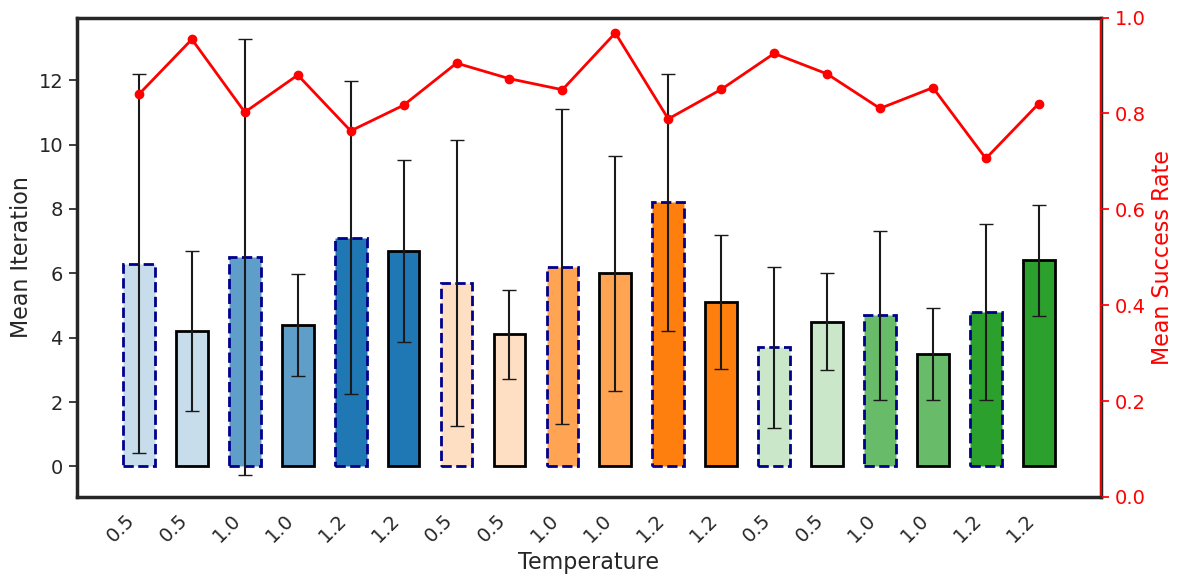

In [21]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.colors as mcolors

# Assume agg_df is already defined with columns:
# ['model','variation','temp',
#  'mean_steps','std_steps','mean_attempts','std_attempts']

# 1) Compute success rate
agg_df['success_rate'] = agg_df['mean_steps'] / agg_df['mean_attempts']

# 2) Filter & sort
plot_df = agg_df[agg_df['variation'].isin([1, 2, 3])].copy()
plot_df.sort_values(['variation', 'temp'], inplace=True)
plot_df.reset_index(drop=True, inplace=True)

# 3) Color setup
base_variation_colors = {1: 'tab:blue', 2: 'tab:orange', 3: 'tab:green'}
def adjust_color_brightness(color, temp):
    base = np.array(mcolors.to_rgb(color))
    white = np.array([1, 1, 1])
    tn = (temp - 0.5) / (1.2 - 0.5)
    tn = np.clip(tn, 0.25, 1)
    return tuple(white * (1 - tn) + base * tn)

# 4) Plot setup
sns.set_theme(style="white")
x = np.arange(len(plot_df))
width = 0.6

fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot only mean_steps bars
for i, row in plot_df.iterrows():
    color = adjust_color_brightness(base_variation_colors[row['variation']], row['temp'])
    edgecol = '#00008B' if row['model']=='gpt' else 'black'
    ls = 'dashed' if row['model']=='gpt' else 'solid'
    ax1.bar(
        x[i], row['mean_steps'], width,
        yerr=row['std_steps'], capsize=5,
        color=color, edgecolor=edgecol,
        linewidth=2, linestyle=ls,
        label=f"Var {row['variation']}" if row['variation'] not in plot_df['variation'][:i].values else ""
    )

# 5) Success rate line on secondary axis
ax2 = ax1.twinx()
ax2.plot(
    x, plot_df['success_rate'], 
    color='red', marker='o', linestyle='-', linewidth=2,
    label='Success Rate'
)

# Color the success-rate axis red
ax2.tick_params(axis='y', colors='red', labelsize=14)
ax2.spines['right'].set_color('red')
ax2.set_ylabel('Mean Success Rate', fontsize=16, color='red')
ax2.set_ylim(0, 1)

# 6) Formatting primary axis
ax1.set_xticks(x)
ax1.set_xticklabels(plot_df['temp'].astype(str), rotation=45, ha='right', fontsize=14)
ax1.set_ylabel('Mean Iteration', fontsize=16)
ax1.set_xlabel('Temperature', fontsize=16)
ax1.tick_params(axis='y', labelsize=14)
ax1.grid(False)
for spine in ax1.spines.values():
    spine.set_linewidth(2.5)

# 7) Legend
h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
# ax1.legend(h1+h2, l1+l2, loc='upper left', fontsize=12)
plt.savefig('./figures/box_iteration_task2.png', dpi=600, bbox_inches='tight')
plt.tight_layout()
plt.show()


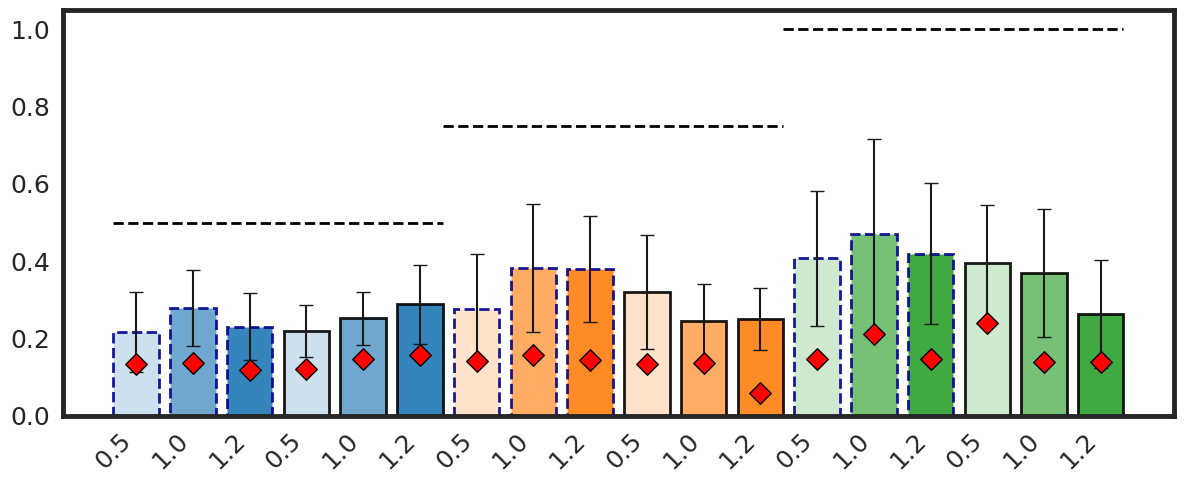

In [22]:


# Set seaborn style WITHOUT grid
sns.set_theme(style="white")

# Filter just variations 1, 2, 3
plot_df = agg_df[agg_df['variation'].isin([1, 2, 3])].copy()

# Create x-axis labels (Model-Temp)
plot_df['label'] = plot_df.apply(lambda row: f"{row['temp']}", axis=1)

# Base colors for variations
base_variation_colors = {
    1: 'tab:blue',
    2: 'tab:orange',
    3: 'tab:green'
}

# Correct shading function: interpolate between white and base color
def adjust_color_brightness(color, temp):
    base_color = np.array(mcolors.to_rgb(color))
    white = np.array([1, 1, 1])
    
    temp_norm = (temp - 0.5) / (1.2 - 0.5)  # normalize temp between 0 and 1
    temp_norm = np.clip(temp_norm, 0.25, 1)
    
    adjusted_color = white * (1 - temp_norm) + base_color * temp_norm
    return tuple(adjusted_color)

# Prepare bar positions
x = np.arange(len(plot_df))

# Create figure
fig, ax = plt.subplots(figsize=(12,5))

#
# Track plotted variations to avoid duplicate legends
plotted_variations = set()

# Plot bars manually
for i, (idx, row) in enumerate(plot_df.iterrows()):
    # Always pick base color by variation
    base_color = base_variation_colors[row['variation']]
    color = adjust_color_brightness(base_color, row['temp'])
    
    edgecolor = 'black'
    linestyle = 'solid'
    
    # Special dashed edge for GPT models
    if row['model'] == 'gpt':
        edgecolor = '#00008B'  # dark blue edge
        linestyle = 'dashed'
    
    label = f'Variation {row["variation"]}' if row['variation'] not in plotted_variations else ""
    
    bar = ax.bar(
        x[i],
        row['mean_best_max_stress_to_weight_ratio'],
        yerr=row['std_best_max_stress_to_weight_ratio'],
        capsize=5,
        color=color,
        edgecolor=edgecolor,
        linewidth=2,
        alpha=0.9,
        label=label
    )
    
    # If GPT, set dashed edge
    if row['model'] == 'gpt':
        bar[0].set_linestyle(linestyle)
    
    # Mark best_stress with a red diamond
    ax.scatter(
        x[i],
        row['best_max_stress_to_weight_ratio'],
        color='red',
        marker='D',
        s=120,
        edgecolors='black',
        zorder=5
    )
    
    plotted_variations.add(row['variation'])

first_bar = x[0] - 0.4  # left edge
sixth_bar = x[5] + 0.4  # right edge

ax.hlines(
    y=0.5, xmin=first_bar, xmax=sixth_bar,
    colors='black', linestyles='dashed', linewidth=2
)

eleven_bar = x[11] + 0.4  # right edge
ax.hlines(
    y=0.75, xmin=sixth_bar, xmax=eleven_bar,
    colors='black', linestyles='dashed', linewidth=2
)

last_bar = x[-1] + 0.4  # right edge
ax.hlines(
    y=1.0, xmin=eleven_bar, xmax=last_bar,
    colors='black', linestyles='dashed', linewidth=2
)


# Set labels
ax.set_xticks(x)
ax.set_xticklabels(plot_df['label'], rotation=45, ha='right', fontsize=18)

# make y tick bigger
ax.tick_params(axis='y', labelsize=18)

# Remove grid
ax.grid(False)

#make thick borders
for spine in ax.spines.values():
    spine.set_visible(True)
    spine.set_linewidth(3.5)

# Add Legend
handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))

plt.tight_layout()
# plt.savefig("./figures/stress_plot_q2.png", dpi=600)
plt.show()
